In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import time

# custom libs
import sys
sys.path.append("..")
from src.simulations import simulate_curves, generate_coeffs
from src.dynamicFPC import K_dFPC, W_dFPC

c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:653: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Wavelet-based decomposition: $\hat{h}$")
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:671: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(self.scores[i, :], label=f"$\eta_{i}$")
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:674: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(self.scores[i, :], label=f"$\eta_{i}$", alpha=alpha_)
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:677: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Wavelet-based decomposition: $\eta{h}$")


In [2]:
def print_truncated(i, step):
    if i % step == 0:
        print(f"\t {i}")

In [99]:
doc_path = "../../densities4risk_doc/Figures/"

# Sample data

In [3]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
phis = generate_coeffs(d) # AR(1) model coefficients
variance = 1.5

Y, X, mEps = simulate_curves(
                        n,
                        nt,
                        u,
                        phis, 
                        variances=np.full(len(phis), variance)
                        )

In [4]:
T, n = X.shape
x_support = np.arange(T)  

fig = go.Figure()

color_original = "#06d6a0"
color_observed = "#8338ec"

# Unobserved curves (X)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=X[:, j],
            mode="lines",
            line=dict(color=color_original, dash="dash"),
            opacity=0.6,
            showlegend=(j == 0),
            name="Unobserved"
        )
    )

# Observed curves (Y)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=Y[:, j],
            mode="lines",
            line=dict(color=color_observed),
            opacity=0.6,
            showlegend=(j == 0),
            name="Observed"
        )
    )

# Mean curve
fig.add_trace(
    go.Scatter(
        x=x_support,
        y=np.mean(Y, axis=1),
        mode="lines",
        line=dict(color="black", width=3),
        name="Mean(Y)"
    )
)

fig.update_layout(
    title=f"{n} Curves: Original ({color_original}) and Observed ({color_observed})",
    xaxis_title="Index",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()


# Simulations

## Estimating dimensions

In [16]:
# -----------------------
# WdFPC configuration
# -----------------------
WdFPC_kwargs = {
    "wavelet": "db2",
    "N": 3,
    "p": 5,
    "d": d,
    "nt": nt,
}

# -----------------------
# KdFPC configuration
# -----------------------
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": nt,
    "u": u,
    "select_ncomp": False,
    "dimension": d,
}

In [17]:
# Repetitions
R = 10_000

# Variable
D = 10

timings = {}
for d in range(1, D+1):
    print(f">>>Initiating simulations for d={d}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    phis = generate_coeffs(d)

    for r in range(R):
        print_truncated(r,200)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = d
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = d
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings[d] = df_timing

>>>Initiating simulations for d=1
	 0


c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:653: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Wavelet-based decomposition: $\hat{h}$")
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:671: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(self.scores[i, :], label=f"$\eta_{i}$")
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:674: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(self.scores[i, :], label=f"$\eta_{i}$", alpha=alpha_)
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:677: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Wavelet-based decomposition: $\eta{h}$")


ValueError: negative dimensions are not allowed

In [32]:
df = pd.DataFrame()

for k in timings.keys():
    df0 = timings[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [39]:
df.columns = ["WdFPC", "KdFPC", "d"]

In [46]:
print(f"Median of {R:,} simulations for estimating each d of {D} dimensions for {n} curves")
df.groupby("d").median()

Median of 10,000 simulations for estimating each d of 10 dimensions for 100 curves


,WdFPC,KdFPC
d,,
1,0.063722,0.004133
2,0.063787,0.003703
3,0.063029,0.004528
4,0.059256,0.003807
5,0.060620,0.004483
6,0.060661,0.004542
7,0.055070,0.003470
8,0.060443,0.004564
9,0.059066,0.004598


In [35]:
df.to_excel("../data/processed/time_simulation_dim.xlsx", index=False)

## Changing number of curves

array([ 100,  250,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
       5000])

In [36]:
# Repetitions
R = 100

# Variable
N = np.append(
            np.array([100,250]), 
            np.arange(500,3500,500)
            )


D = 4
phis = generate_coeffs(D)
timings_n = {}
for n in N:
    print(f">>>Initiating simulations for n={n}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    
    for r in range(R):
        print_truncated(r,20)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = D
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = D
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings_n[n] = df_timing

>>>Initiating simulations for n=100
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=250
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=500
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=1000
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=1500
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=2000
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=2500
	 0
	 20
	 40
	 60
	 80
>>>Initiating simulations for n=3000
	 0
	 20
	 40
	 60
	 80


In [37]:
df = pd.DataFrame()

for k in timings_n.keys():
    df0 = timings_n[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [41]:
df

,WdFPC,KdFPC,n
0,0.022588,0.003640,100
1,0.021599,0.002600,100
2,0.019378,0.002642,100
3,0.019362,0.003283,100
4,0.019180,0.002640,100
...,...,...,...
95,0.464137,8.102874,3000
96,0.457619,8.096345,3000
97,0.473277,8.255554,3000
98,0.461505,8.131615,3000


In [38]:
df.columns = ["WdFPC", "KdFPC", "n"]
print(f"Median of {R:,} simulations for estimating n of {N} curves with dimension {4}")
df.groupby("n").median()

Median of 100 simulations for estimating n of [ 100  250  500 1000 1500 2000 2500 3000] curves with dimension 4


,WdFPC,KdFPC
n,,
100,0.019969,0.002776
250,0.028396,0.018957
500,0.048174,0.084781
1000,0.090447,0.412790
1500,0.152120,1.196152
2000,0.233410,2.649219
2500,0.342666,4.915077
3000,0.460297,8.144016


In [39]:
df.to_excel("../data/processed/time_simulation_n_2.xlsx", index=False)

In [ ]:
df_long = df.melt(
    id_vars="n",
    value_vars=["WdFPC", "KdFPC"],
    var_name="Method",
    value_name="Time"
)

# make sure n is categorical
df_long["n"] = df_long["n"].astype(str)

In [96]:
palette = {
    "WdFPC": "#8338ec",  # blue
    "KdFPC": "#4ae867",  # orange
}

<Figure size 1000x500 with 0 Axes>

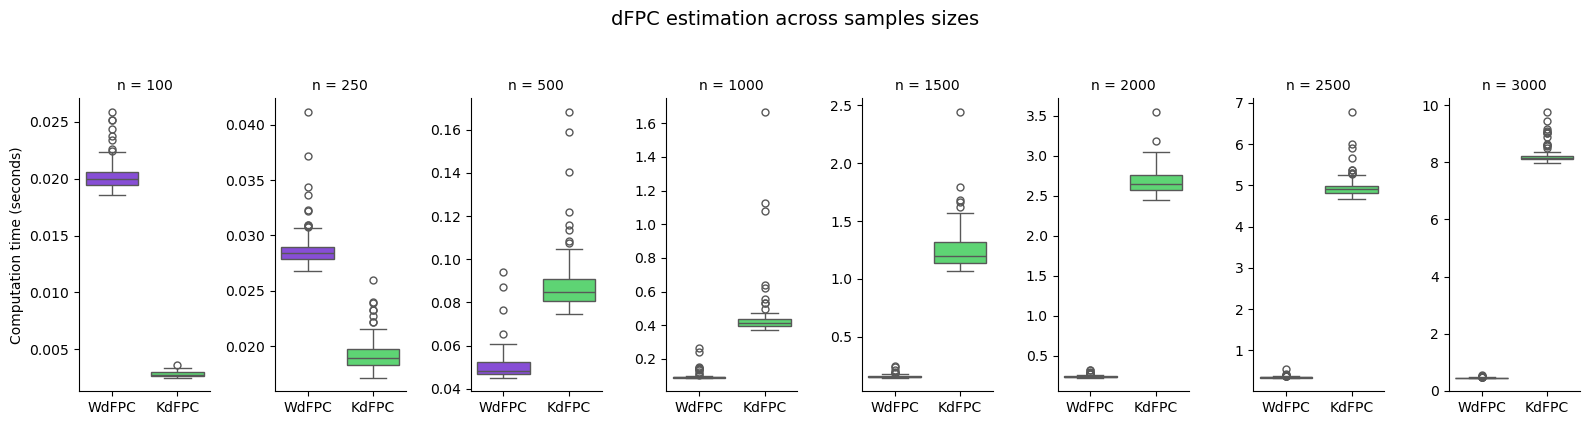

In [111]:
plt.figure(figsize=(10, 5))

# sns.violinplot(
#     data=df_long,
#     x="n",
#     y="Time",
#     hue="Method",
#     split=False,   # keep violins side-by-side, not split
#     inner="quartile",
#     cut=0
# )

g = sns.catplot(
    data=df_long,
    x="Method",
    y="Time",
    col="n",
    kind="box",
    hue="Method",
    # kind="violin",
    # inner="quartile",
    # cut=0,
    sharey=False,
    height=4,
    aspect=0.5,
    palette=palette
)
for ax in g.axes.flatten():
    ax.set_xlabel("")   # remove "Method"

g.figure.suptitle(
    "dFPC estimation across samples sizes",
    fontsize=14,
    y=1.05
)
g.set_ylabels("Computation time (seconds)")

plt.tight_layout()
plt.savefig(''.join([doc_path, 'sim_n_boxplot.png']))

C:\Users\user\AppData\Local\Temp\ipykernel_13676\371496547.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


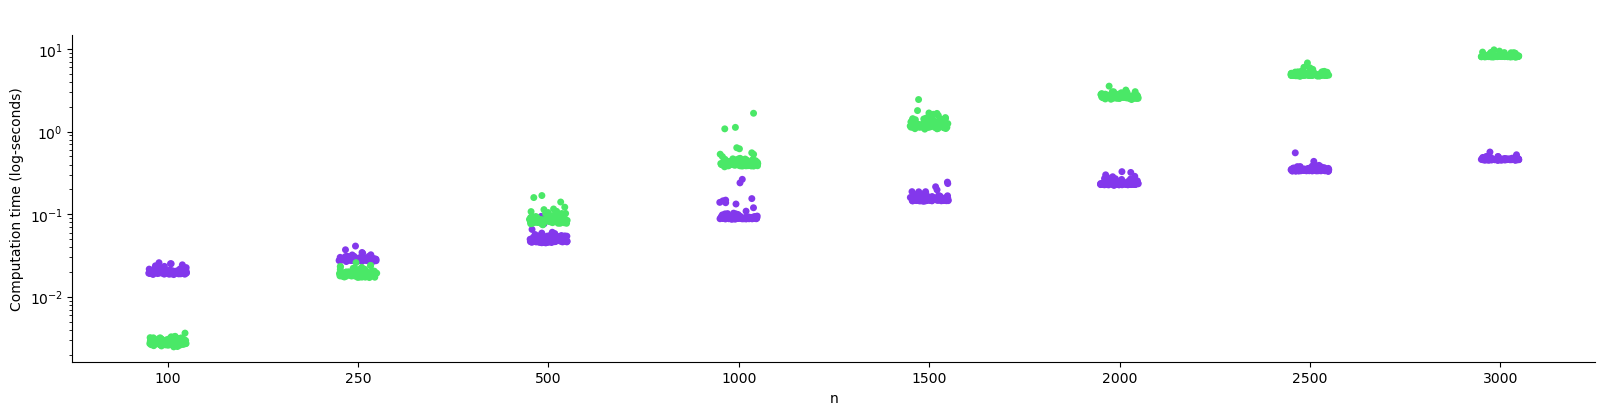

In [113]:
g = sns.catplot(
    data=df_long,
    x="n",
    y="Time",
    hue="Method",
    height=4,
    aspect=4,
    palette=palette,
    legend=False
)

# g.figure.suptitle(
#     "dFPC estimation across samples sizes",
#     fontsize=14,
#     y=1.05
# )
g.set_ylabels("Computation time (log-seconds)")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    frameon=False,
    title=None
)

plt.yscale("log")

plt.savefig(''.join([doc_path, 'sim_n_scatter.png']))